# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator

from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal

%matplotlib inline
reload(dt)

# Global params
root = pathlib.Path("/data")

BIN_SIZE = .03  # sec
WINDOW_prep = (-.4, .05)  # sec
WINDOW_exec = (-.05, .40)  # sec
n_components = 10  # min between M1 and PMd
areas = ('M1', 'PMd')

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                    )
fixation_epoch = pyal.generate_epoch_fun(start_point_name='idx_target_on', 
                                         rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                         rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                        )

preprocessing

In [2]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

In [3]:
def prep_general (df, area='M1'):
    "preprocessing general!"
    
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_ = pyal.remove_low_firing_neurons(df, f"{area}_spikes", 1)
    
    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    assert np.all(df_.bin_size == .01), 'bin size is not consistent!'
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    
    df_ = pyal.sqrt_transform_signal(df_, f"{area}_spikes")
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    
    return df_


%run dataset_selection.ipynb

the variable `GoodDataList` contains the session names




---

back to the original idea:

1. this:
> # Compare different epochs
> the idea is to see whether canonical axes between 2 animals provide a higher VAF for time epochs in the trial that they have not been trained on, compared to, for example, M1-PMd axes in a single animal.

2. and a similar but different idea:
> two monkeys during the same epoch vs. one monkey between 2 different epochs.
i.e., preparation vs execution, ...

#### Try the second idea first:

# 2 monkeys, same epoch

load the data

In [5]:
pairFileList1 = []
for I, animal1 in enumerate(GoodDataList[areas[0]]):
    for J, animal2 in enumerate(GoodDataList[areas[0]]):
        if J<=I or '2' in animal1+animal2:  # to repetitions and to remove Chewie2
            continue
        path1List = [root/animal1/GoodDataList[areas[0]][animal1][i] for i,_ in enumerate(GoodDataList[areas[0]][animal1])]
        path2List = [root/animal2/GoodDataList[areas[0]][animal2][i] for i,_ in enumerate(GoodDataList[areas[0]][animal2])]
        for path1 in path1List:
            df1 = dt.load_pyal_data(path1)
            for path2 in path2List:
                pairFileList1.append((df1, dt.load_pyal_data(path2)))

print(f'{len(pairFileList1)=}')


pairFileList2 = []
for I, animal1 in enumerate(GoodDataList[areas[1]]):
    for J, animal2 in enumerate(GoodDataList[areas[1]]):
        if J<=I or '2' in animal1+animal2:  # to repetitions and to remove Chewie2
            continue
        path1List = [root/animal1/GoodDataList[areas[1]][animal1][i] for i,_ in enumerate(GoodDataList[areas[1]][animal1])]
        path2List = [root/animal2/GoodDataList[areas[1]][animal2][i] for i,_ in enumerate(GoodDataList[areas[1]][animal2])]
        for path1 in path1List:
            df1 = dt.load_pyal_data(path1)
            for path2 in path2List:
                pairFileList2.append((df1, dt.load_pyal_data(path2)))

print(f'{len(pairFileList2)=}')


warnings.filterwarnings("ignore")
gc.collect()
pairFileList_area0 = [(prep_general(df1),prep_general(df2)) for  df1,df2 in pairFileList1]
del pairFileList1
gc.collect()
pairFileList_area1 = [(prep_general(df1),prep_general(df2)) for  df1,df2 in pairFileList2]
del pairFileList2
gc.collect()
warnings.filterwarnings("default")

len(pairFileList1)=33
len(pairFileList2)=33


collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

min_trials=16
min_time=15
min_trials_=15
min_time_=15


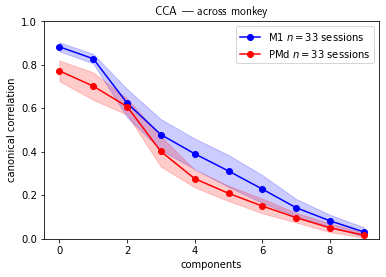

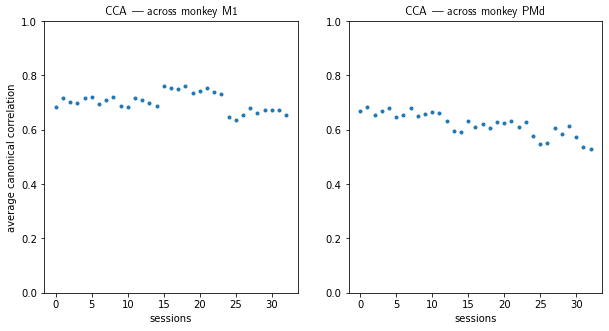

In [6]:
side1df = [df for df,_ in pairFileList_area0]
side2df = [df for _,df in pairFileList_area0]
AllData1 = dt.get_data_array(side1df, exec_epoch, area=areas[0], n_components=n_components)
AllData2 = dt.get_data_array(side2df, exec_epoch, area=areas[0], n_components=n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

side1df = [df for df,_ in pairFileList_area1]
side2df = [df for _,df in pairFileList_area1]
AllData1_ = dt.get_data_array(side1df, prep_epoch, area=areas[1], n_components=n_components)
AllData2_ = dt.get_data_array(side2df, prep_epoch, area=areas[1], n_components=n_components)
_,_, min_trials_, min_time_,_ = np.min((AllData1_.shape,AllData2_.shape),axis=0)
print(f'{min_trials_=}\n{min_time_=}')


allCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_components))
    allCCs0.append(dt.canoncorr(data1, data2))
allCCs0 = np.array(allCCs0).T

allCCs1=[]
for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
    data1 = np.reshape(sessionData1[:,:min_trials_,:min_time_,:], (-1,n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_,:min_time_,:], (-1,n_components))
    allCCs1.append(dt.canoncorr(data1, data2))
allCCs1 = np.array(allCCs1).T

# plot
_,ax = plt.subplots()
utility.shaded_errorbar(ax, allCCs0, color='b', marker = 'o', label=f'{areas[0]} $n={allCCs0.shape[1]}$ sessions')
utility.shaded_errorbar(ax, allCCs1, color='r', marker = 'o', label=f'{areas[1]} $n={allCCs1.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('components')
ax.legend()
ax.set_ylabel('canonical correlation')
ax.set_title('CCA --- across monkey', usetex=True);

_,axes = plt.subplots(ncols=2, figsize=(10,5))
axes[0].plot(allCCs0[:4,:].mean(axis=0),'.')
axes[1].plot(allCCs1[:4,:].mean(axis=0),'.')
axes[0].set_ylabel('average canonical correlation')
for i, ax in enumerate(axes):
    ax.set_title(f'CCA --- across monkey {areas[i]} ', usetex=True);
    ax.set_ylim([0,1])
    ax.set_xlabel('sessions')


# one monkey, 2 epochs

In [7]:
pairFileList1 = []
for animal1 in GoodDataList[areas[0]]:
    path1List = [root/animal1/GoodDataList[areas[0]][animal1][i] for i,_ in enumerate(GoodDataList[areas[0]][animal1])]
    for path1 in path1List:
        df1 = dt.load_pyal_data(path1)
        pairFileList1.append(df1)

print(f'{len(pairFileList1)=}')


pairFileList2 = []
for animal1 in GoodDataList[areas[1]]:
    path1List = [root/animal1/GoodDataList[areas[1]][animal1][i] for i,_ in enumerate(GoodDataList[areas[1]][animal1])]
    for path1 in path1List:
        df1 = dt.load_pyal_data(path1)
        pairFileList2.append(df1)



warnings.filterwarnings("ignore")
gc.collect()
pairFileList_area0 = [prep_general(df) for df in pairFileList1]
del pairFileList1
gc.collect()
pairFileList_area1 = [prep_general(df) for  df in pairFileList2]
del pairFileList2
gc.collect()
warnings.filterwarnings("default")

len(pairFileList1)=14


min_trials=16
min_time=15
min_trials_=15
min_time_=15


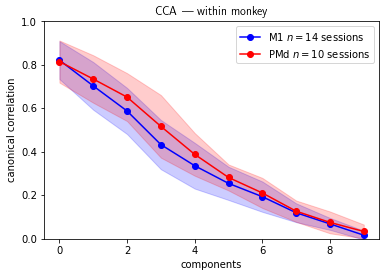

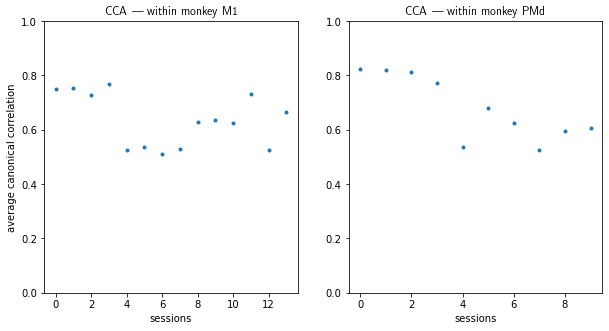

In [8]:
warnings.filterwarnings("ignore")
side1df = pairFileList_area0
AllData1 = dt.get_data_array(side1df, prep_epoch, area=areas[0], n_components=n_components)
AllData2 = dt.get_data_array(side1df, exec_epoch, area=areas[0], n_components=n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')
# PMd
side2df = pairFileList_area1
AllData1_ = dt.get_data_array(side2df, prep_epoch, area=areas[1], n_components=n_components)
AllData2_ = dt.get_data_array(side2df, exec_epoch, area=areas[1], n_components=n_components)
_,_, min_trials_, min_time_,_ = np.min((AllData1_.shape,AllData2_.shape),axis=0)
print(f'{min_trials_=}\n{min_time_=}')

inCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_components))
    inCCs0.append(dt.canoncorr(data1, data2))
inCCs0 = np.array(inCCs0).T

inCCs1=[]
for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
    data1 = np.reshape(sessionData1[:,:min_trials_,:min_time_,:], (-1,n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_,:min_time_,:], (-1,n_components))
    inCCs1.append(dt.canoncorr(data1, data2))
inCCs1 = np.array(inCCs1).T
warnings.filterwarnings("default")

# plotting
_,ax = plt.subplots()

utility.shaded_errorbar(ax, inCCs0, color='b', marker = 'o', label=f'{areas[0]} $n={inCCs0.shape[1]}$ sessions')
utility.shaded_errorbar(ax, inCCs1, color='r', marker = 'o', label=f'{areas[1]} $n={inCCs1.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('components')
ax.legend()
ax.set_ylabel('canonical correlation')
ax.set_title('CCA --- within monkey', usetex=True);

fig,axes = plt.subplots(ncols=2, figsize=(10,5))
axes[0].plot(inCCs0[:4,:].mean(axis=0),'.')
axes[1].plot(inCCs1[:4,:].mean(axis=0),'.')
axes[0].set_ylabel('average canonical correlation')
for i, ax in enumerate(axes):
    ax.set_title(f'CCA --- within monkey {areas[i]} ', usetex=True);
    ax.set_ylim([0,1])
    ax.set_xlabel('sessions')

across monkey and within monkey together

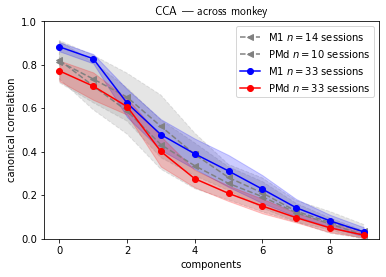

In [9]:
# plot
_,ax = plt.subplots()

utility.shaded_errorbar(ax, inCCs0, color='gray', marker = '<', ls='--', label=f'{areas[0]} $n={inCCs0.shape[1]}$ sessions')
utility.shaded_errorbar(ax, inCCs1, color='gray', marker = '<', ls='--', label=f'{areas[1]} $n={inCCs1.shape[1]}$ sessions')

utility.shaded_errorbar(ax, allCCs0, color='b', marker = 'o', label=f'{areas[0]} $n={allCCs0.shape[1]}$ sessions')
utility.shaded_errorbar(ax, allCCs1, color='r', marker = 'o', label=f'{areas[1]} $n={allCCs1.shape[1]}$ sessions')


ax.set_ylim([0,1])
ax.set_xlabel('components')
ax.legend()
ax.set_ylabel('canonical correlation')
ax.set_title('CCA --- across monkey', usetex=True);

---

# VAF?

In [35]:
def get_unit_data_and_pca(data_list: list[pd.DataFrame], epoch , area: str ='M1', n_components: int =10) -> tuple[np.ndarray, sklearn.decomposition._pca.PCA]:
    """
    Applies PCA to the data and return a data matrix of the shape: sessions x targets x  trials x time x PCs
    with the minimum number of trials and timepoints shared across all the datasets/targets.
    
    Parameters
    ----------
    `data_list`: list of pd.dataFrame datasets from pyal-data
    `epoch`: an epoch function of the type `pyal.generate_epoch_fun`
    `area`: area, either: 'M1', or 'S1', or 'PMd'

    Returns
    -------
    `AllData`: np.array
    `AllPCA`: list of pca objects of each session

    Signature
    -------
    AllData = get_data_array(data_list, execution_epoch, area='M1', n_components=10)
    all_data = np.reshape(AllData, (-1,10))
    """
    field = f'{area}_rates'
    n_shared_trial = np.inf
    n_unit = np.inf
    for df in data_list:
        n_unit = np.min((df[field][0].shape[1], n_unit))
        for target in range(8):
            df_ = pyal.select_trials(df, df.target_id== target)
            n_shared_trial = np.min((df_.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)
    n_unit = int(n_unit)

    # finding the number of timepoints
    df_ = pyal.restrict_to_interval(df_,epoch_fun=epoch)
    n_timepoints = int(df_[field][0].shape[0])

    # pre-allocating the data matrix
    AllData = np.empty((len(data_list), 8, n_shared_trial, n_timepoints, n_unit))
    AllPCA = []
    rng = np.random.default_rng(12345)
    for session, df in enumerate(data_list):
        df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
        rates = np.concatenate(df_[field].values, axis=0)
        rates -= np.mean(rates, axis=0)
        all_units = np.arange(rates.shape[1])
        rng.shuffle(all_units)
        rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates[:,all_units[:n_unit]])
        AllPCA.append(rates_model)
        
        for target in range(8):
            df__ = pyal.select_trials(df_, df_.target_id==target)
            all_id = df__.trial_id.to_numpy()
            rng.shuffle(all_id)
            # select the right number of trials to each target
            df__ = pyal.select_trials(df__, lambda trial: trial.trial_id in all_id[:n_shared_trial])
            for trial, trial_rates in enumerate(df__[field]):
                AllData[session,target,trial, :, :] = trial_rates [:,all_units[:n_unit]]
    
    return AllData, AllPCA


## 2 monkeys, same epoch

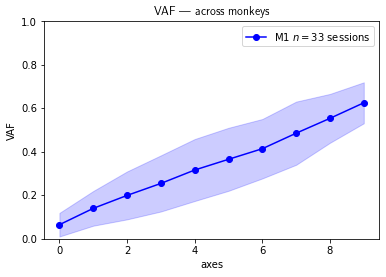

In [63]:
warnings.filterwarnings("ignore")
pairFileList1 = []
for I, animal1 in enumerate(GoodDataList[areas[0]]):
    for J, animal2 in enumerate(GoodDataList[areas[0]]):
        if J<=I or '2' in animal1+animal2:  # to repetitions and to remove Chewie2
            continue
        path1List = [root/animal1/GoodDataList[areas[0]][animal1][i] for i,_ in enumerate(GoodDataList[areas[0]][animal1])]
        path2List = [root/animal2/GoodDataList[areas[0]][animal2][i] for i,_ in enumerate(GoodDataList[areas[0]][animal2])]
        for path1 in path1List:
            df1 = dt.load_pyal_data(path1)
            for path2 in path2List:
                pairFileList1.append((df1, dt.load_pyal_data(path2)))


gc.collect()
pairFileList_area0 = [(prep_general(df1),prep_general(df2)) for  df1,df2 in pairFileList1]
del pairFileList1
gc.collect()
warnings.filterwarnings("default")

side1df = [df for df,_ in pairFileList_area0]
side2df = [df for _,df in pairFileList_area0]
AllData1, AllPca1 = get_unit_data_and_pca(side1df, exec_epoch, area=areas[0], n_components=n_components)
AllData2, AllPca2 = get_unit_data_and_pca(side2df, exec_epoch, area=areas[0], n_components=n_components)
_,_, min_trials, min_time, _ = np.min((AllData1.shape,AllData2.shape),axis=0)


allVAFs=[]
for sessionData1,sessionData2, model1, model2 in zip(AllData1, AllData2, AllPca1, AllPca2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,sessionData1.shape[-1]))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,sessionData2.shape[-1]))
    A, B, *_ = dt.canoncorr(model1.transform(data1), model2.transform(data2), fullReturn=True)
    allVAFs.append(dt.VAF_pc_cc(X=data1, C=model1.components_, A=A))
allVAFs = np.array(allVAFs).T


# plot
_,ax = plt.subplots()
utility.shaded_errorbar(ax, np.cumsum(allVAFs,axis=0), color='b', marker = 'o', label=f'{areas[0]} $n={allVAFs.shape[1]}$ sessions')
# utility.shaded_errorbar(ax, allCCs1, color='r', marker = 'o', label=f'{areas[1]} $n={allCCs1.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('axes')
ax.legend()
ax.set_ylabel('VAF')
ax.set_title('VAF --- across monkeys', usetex=True);

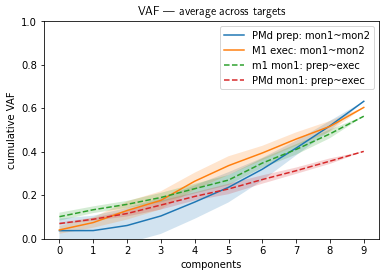

In [7]:
fig,ax = plt.subplots()


CC=[]

for target in range(8):
    # PMd prep: mon1~mon2
    a,b,_ = dt.VAF_pc_cc_pyal2(df1=df_data_ready[1], field1='PMd_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='PMd_rates', epoch2=prep_epoch, target2=target)
    CC.append((a+b)/2)

    # M1 exec: mon1~mon2
    a,b,_ = dt.VAF_pc_cc_pyal2(df1=df_data_ready[0], field1='M1_rates', epoch1=exec_epoch, target1=target,
                            df2=df_data_ready[1], field2='M1_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)

    # m1 mon1: prep~exec
    a,b,_ = dt.VAF_pc_cc_pyal2(df1=df_data_ready[0], field1='M1_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='M1_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)

    # PMd mon1: prep~exec
    a,b,_ = dt.VAF_pc_cc_pyal2(df1=df_data_ready[0], field1='PMd_rates', epoch1=prep_epoch, target1=target,
                            df2=df_data_ready[0], field2='PMd_rates', epoch2=exec_epoch, target2=target)
    CC.append((a+b)/2)


CC= np.array(CC)

utility.shaded_errorbar(ax,np.cumsum(CC[0::4,:].T,axis=0), label='PMd prep: mon1~mon2')
utility.shaded_errorbar(ax,np.cumsum(CC[1::4,:].T,axis=0), label='M1 exec: mon1~mon2')
utility.shaded_errorbar(ax,np.cumsum(CC[2::4,:].T,axis=0),ls='--',label='m1 mon1: prep~exec')
utility.shaded_errorbar(ax,np.cumsum(CC[3::4,:].T,axis=0),ls='--',label='PMd mon1: prep~exec')

ax.set_xlabel('components')
ax.set_ylabel('cumulative VAF')
ax.legend()
ax.set_ylim([0,1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('VAF --- average across targets', usetex=True);